# Train a small model that can be used by the Starlette app to tell the difference between digits and non-digits.

The 2 main steps are;
- Use regression, rather than classification, so the model tells us how much digit it can find in the image
- Find the best value we can use to split the continuous output of the model into 2 groups (digits or not digits).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from nbdev_quick import *
nbdev_quick.init()

See `020_not_digits_from_mnist.ipynb` for details of the "mnist_or_not" dataset.

In [2]:
path = untar_data(URLs.MNIST).parent/'mnist_or_not'

In [3]:
%%nbdev_export
def mnist_or_not_data(path, stats=None, label_dtype=float):
    tfms=get_transforms(do_flip=False)
    return (ImageList.from_folder(path)
        .split_by_folder(train='training', valid='testing')
        .label_from_func(lambda x: label_dtype(0) if 'not' in x.parts[-2] else label_dtype(1))
        .transform(tfms, size=28)
        .databunch(bs=256)
        .normalize(imagenet_stats))

In [4]:
data = mnist_or_not_data(path,imagenet_stats)

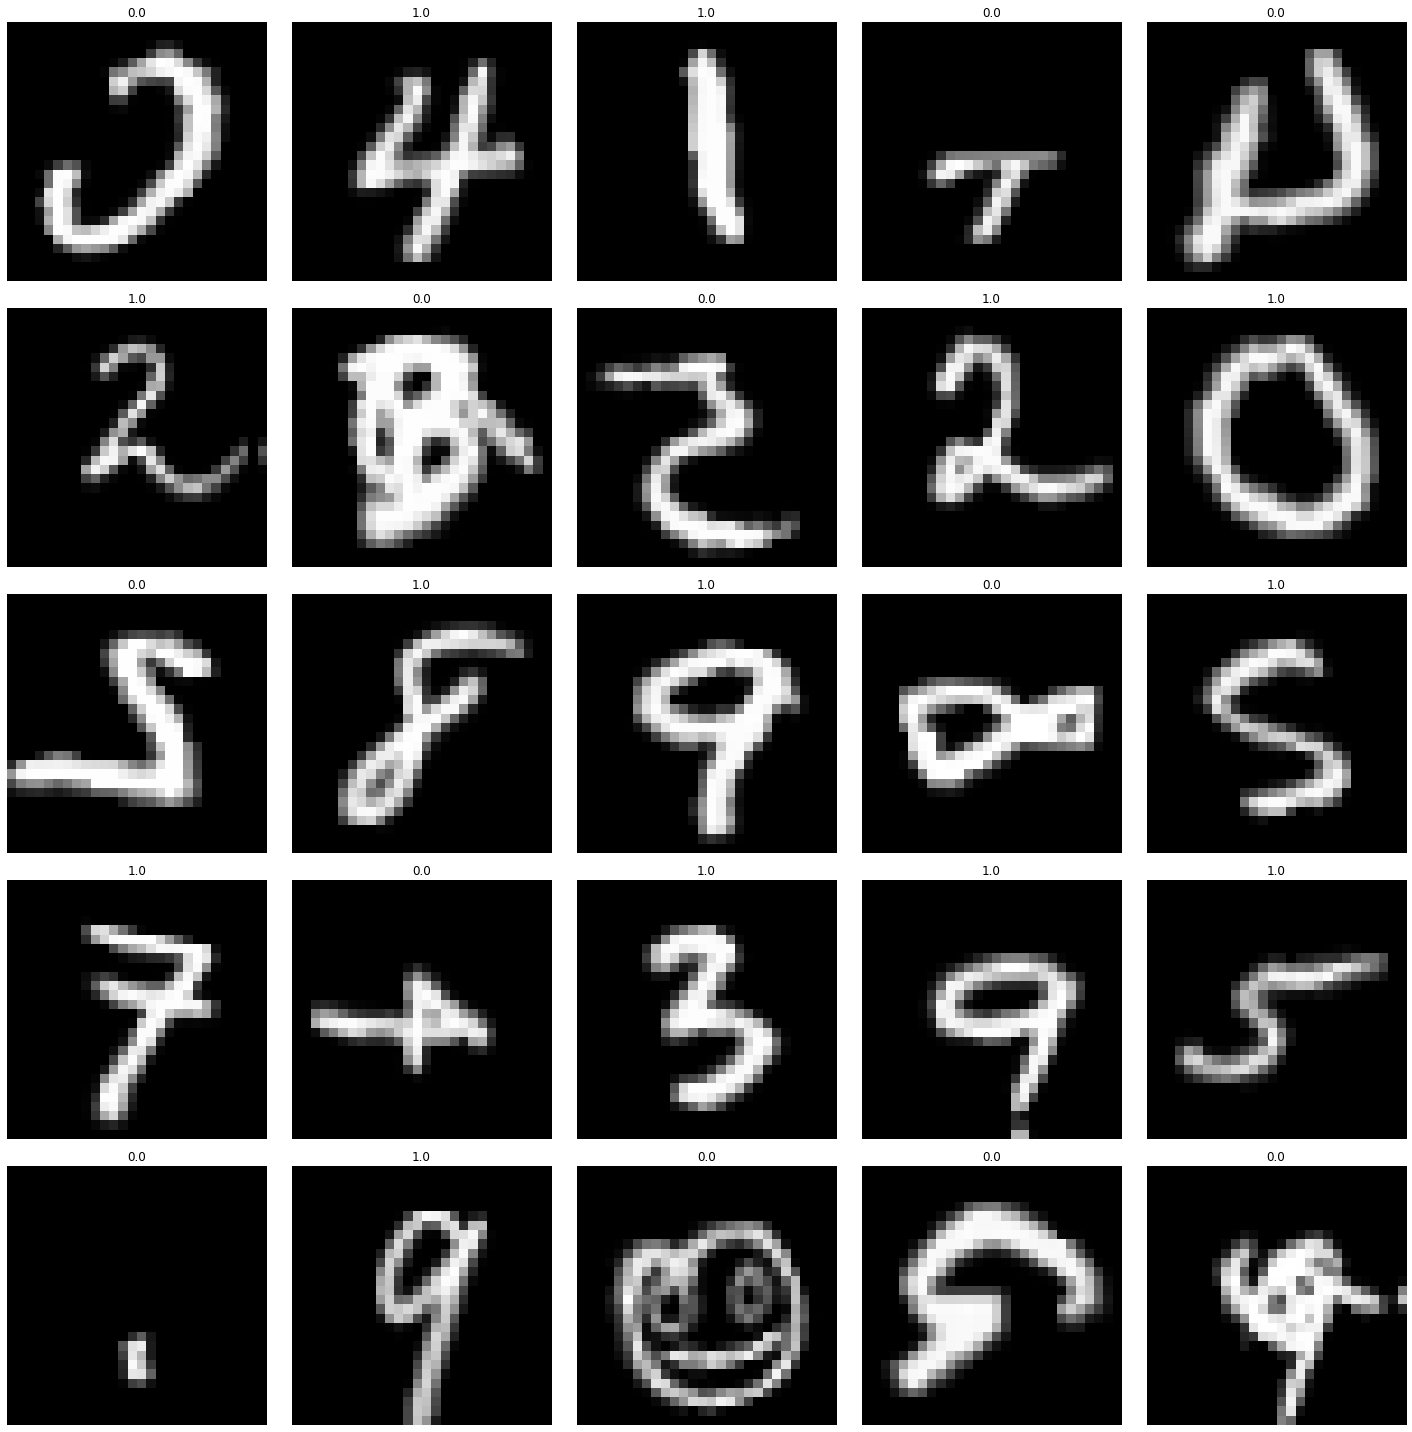

In [5]:
data.show_batch()

sigmoid reduced accuracy so we'll not use it

while we're training the model to hit targets of 0 and 1, we don't care what numbers the model outputs - as long as we can find an accurate threshold 
```python
class SigmoidWithRange(nn.Module):
    def __init__(self, y_min=0, y_max=1):
        super().__init__()
        self.y_min,self.y_max=y_min,y_max        
    def forward(self, x):
        return (self.y_max-self.y_min) * torch.sigmoid(x) + self.y_min
SigmoidWithRange(-0.1, 1.1)
```

In [6]:
learn = Learner(data, new_model(1), metrics=partial(accuracy_thresh,thresh=.4,sigmoid=False))

In [7]:
learn.summary() # Loss function: FlattenedLoss of MSELoss()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 30, 30]         896        True      
______________________________________________________________________
ReLU                 [32, 30, 30]         0          False     
______________________________________________________________________
MaxPool2d            [32, 15, 15]         0          False     
______________________________________________________________________
Conv2d               [32, 15, 15]         9,248      True      
______________________________________________________________________
ReLU                 [32, 15, 15]         0          False     
______________________________________________________________________
MaxPool2d            [32, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 7, 7]           9,248      True      
___________________________________________________

epoch,train_loss,valid_loss,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


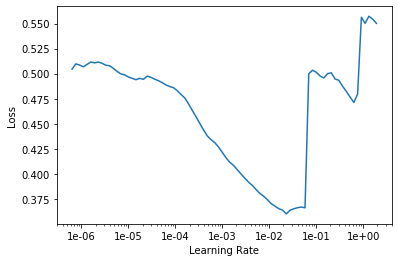

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.091903,0.116201,0.841136,00:20
1,0.068603,0.057556,0.890679,00:22
2,0.052701,0.059163,0.898818,00:22
3,0.039797,0.045598,0.912465,00:22
4,0.034472,0.040648,0.914178,00:22


Note: When compared with `010_mnist_training.ipynb`, we do 10 times as much tranining (5x epochs, 2x data).
Any less than this and the model seems to make a lot of mistakes when tested via the UI.


TODO: quantify and test the effectiveness of this model and compare with a simple classifier

## Find the most accurate threshold value

What is the best value of `thresh` we can use to split predictions into 2 groups (digits or not digits).

Plotting preds vs actuals shows us the most accurate split will be ~0.4

In [10]:
%%nbdev_export
def get_y_preds_and_actuals(learn):
    y_preds,y_actuals=[],[]
    with torch.no_grad():
        for i, (xb, yb) in enumerate(learn.data.valid_dl):
            y_pred = learn.model(xb)
            y_pred = torch.flatten(y_pred)
            y_preds.append(y_pred)
            y_actuals.append(yb)
    return torch.cat(y_preds),torch.cat(y_actuals)

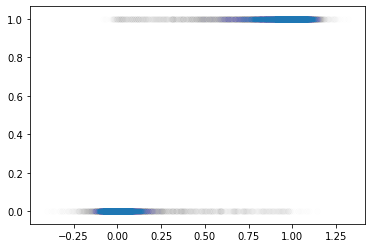

In [11]:
y_preds,y_actuals=get_y_preds_and_actuals(learn)
plt.scatter(y_preds.cpu(), y_actuals.cpu(), alpha=.005);

Try to find the best `thresh` value by;
- starting with a wide range (0 to 1) and wide steps 0.1 then
- searching a smaller range, near the best value found (e.g. 0.7 to 0.9), using smaller steps (e.g. 0.02)
- and repeating the above `max_depth` times

In [12]:
%%nbdev_export
def search_optimal_thresh(start,step,y_preds,y_actuals,result=[0],depth=0,max_depth=3):
    for i in range(11):
        thresh=(i*step)+start
        acc=accuracy_thresh(y_preds,y_actuals,thresh,False).item()
        if acc>result[0]: result=[acc,thresh]
    if depth<max_depth:
        return search_optimal_thresh(result[1]-step, step/5, y_preds, y_actuals, result, depth+1, max_depth)
    return result

In [13]:
opt_acc,opt_thresh=search_optimal_thresh(0,.1,y_preds,y_actuals)
print(f'Using threshold of {round(opt_thresh,3)} gives us an accuaracy of {round(opt_acc, 3)}')

Using threshold of 0.4 gives us an accuaracy of 0.953


In [14]:
# we'll need access to the best thresh value at inference time
learn.model.opt_thresh=round(opt_thresh,3)

## Save everything needed to make predictions

In [15]:
learn_export_file_name,data_export_file_name=save('mnist-or-not',learn,data)

### See if the model is consistently accurate across classes of digits

In [16]:
%%nbdev_export
def regressor_acc_vs_classes(learn,ylim):
    """for each class of digit, see how accurate the model is"""
    # TODO: do somthing for not digits
    d,opt_thresh=[],learn.model.opt_thresh
    learn.data.batch_size=2048
    for cls in range(10):
        image_list=ImageList.from_folder(learn.path/f'testing/{cls}')
        learn.data.add_test(image_list)
        xb,_=next(iter(learn.data.test_dl))
        output=learn.model(xb).flatten()
        d.append([cls]+[(output>t).sum().item()/len(xb) for t in [opt_thresh-.1, opt_thresh, opt_thresh+.1]])
    df = pd.DataFrame(d, columns=['Class', '-0.1', opt_thresh, '+0.1'])
    df.plot.bar(x='Class', ylim=ylim); plt.legend(ncol=3); plt.xlabel('Classes');

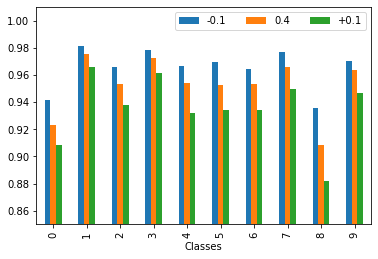

In [17]:
regressor_acc_vs_classes(learn,ylim=(.85,1.01))

## Can we train a more accurate classifier?

This classifier is usually a little more accurate than the regressor (96% vs 95.5%).

TODO: See if both models make the same mistakes - I'm expecting that they will

In [18]:
data = mnist_or_not_data(path,imagenet_stats,label_dtype=int)
learn = Learner(data, new_model(2), metrics=accuracy)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


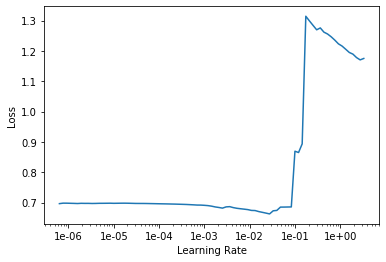

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.261714,0.236325,0.905250,00:21
1,0.202779,0.173003,0.933400,00:22
2,0.161222,0.125234,0.952600,00:22
3,0.122041,0.116617,0.956200,00:22
4,0.104401,0.118839,0.955250,00:22
